
=== Best model per battery (Leave-One-Battery-Out, by RMSE) ===
Battery  BestModel                 MAE       RMSE       R2
B0005    ExtraTrees              1.040      1.316    0.984
B0006    ExtraTrees              5.706      6.266    0.748
B0007    GradientBoosting        0.999      1.288    0.977
B0018    GradientBoosting        2.052      2.439    0.916


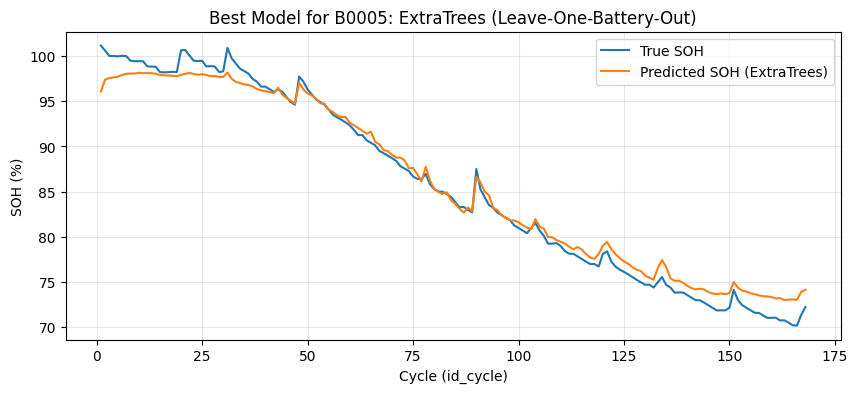

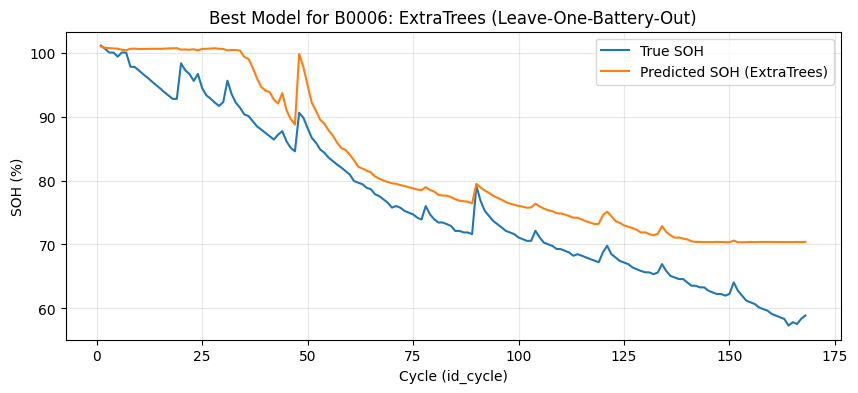

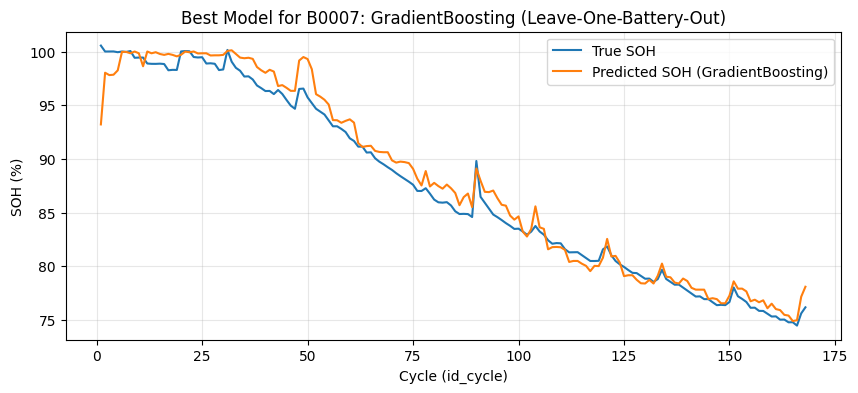

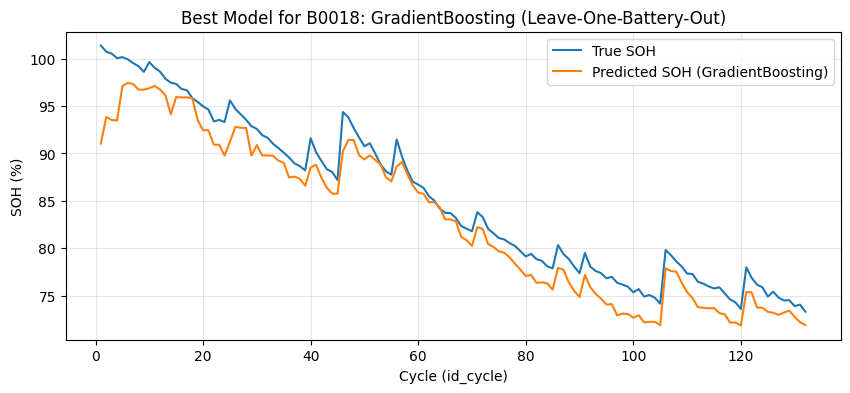

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# ----------------------------
# Configuration
# ----------------------------
DATA_PATH = r"/Users/nima/Documents/Disk E/ML/DATA/Battery Aging/uncleaned Nasa Battery Data/discharge.csv"
USE_CYCLE_PRIOR = False          # recommended for B0006 generalization comparison
RANDOM_STATE = 0


# ----------------------------
# Helpers
# ----------------------------
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


def safe_group_apply(df, group_cols, fn):
    gb = df.groupby(group_cols, sort=False)
    try:
        out = gb.apply(fn, include_groups=False)
    except TypeError:
        out = gb.apply(fn)
    return out


# ----------------------------
# 1) Load data
# ----------------------------
df = pd.read_csv(DATA_PATH)
df = df[df["type"] == "discharge"].copy()

needed = [
    "Battery", "id_cycle",
    "Voltage_measured", "Current_measured", "Temperature_measured",
    "ambient_temperature", "Time", "Capacity"
]
df = df.dropna(subset=needed).copy()

df["id_cycle"] = pd.to_numeric(df["id_cycle"], errors="coerce")
df["Time"] = pd.to_numeric(df["Time"], errors="coerce")
for col in ["Voltage_measured", "Current_measured", "Temperature_measured", "ambient_temperature", "Capacity"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["id_cycle", "Time"]).copy()
df["id_cycle"] = df["id_cycle"].astype(int)


# ----------------------------
# 2) Enhanced cycle-level features (Ah-fraction curve features)
# ----------------------------
def cycle_features(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values("Time")

    t = g["Time"].to_numpy(dtype=float)
    v = g["Voltage_measured"].to_numpy(dtype=float)
    i = g["Current_measured"].to_numpy(dtype=float)
    temp = g["Temperature_measured"].to_numpy(dtype=float)
    amb = g["ambient_temperature"].to_numpy(dtype=float)

    if len(t) < 8:
        return pd.Series(dtype=float)

    duration = t[-1] - t[0]
    if not np.isfinite(duration) or duration <= 0:
        return pd.Series(dtype=float)

    ia = np.abs(i)
    dt = np.diff(t)
    if np.any(dt < 0) or not np.all(np.isfinite(dt)):
        return pd.Series(dtype=float)

    # cumulative Ah
    ah_inc = (ia[:-1] + ia[1:]) * 0.5 * dt / 3600.0
    ah_cum = np.concatenate([[0.0], np.cumsum(ah_inc)])
    ah_total = float(ah_cum[-1])
    if not np.isfinite(ah_total) or ah_total <= 1e-9:
        return pd.Series(dtype=float)

    def v_at_ah_frac(q: float) -> float:
        target = q * ah_total
        x_u, idx = np.unique(ah_cum, return_index=True)
        y_u = v[idx]
        if len(x_u) < 2:
            return float(y_u[0])
        return float(np.interp(target, x_u, y_u))

    v10 = v_at_ah_frac(0.10)
    v50 = v_at_ah_frac(0.50)
    v90 = v_at_ah_frac(0.90)

    def slope_on(q1: float, q2: float) -> float:
        a1, a2 = q1 * ah_total, q2 * ah_total
        mask = (ah_cum >= a1) & (ah_cum <= a2)
        if mask.sum() < 8:
            return np.nan
        x = ah_cum[mask]
        y = v[mask]
        return float(np.polyfit(x - x[0], y, 1)[0])

    slope_early = slope_on(0.0, 0.2)
    slope_mid = slope_on(0.4, 0.6)
    slope_late = slope_on(0.8, 1.0)

    # energy Wh: use trapezoid (np.trapz deprecated)
    p_abs = np.abs(v * i)
    wh = float(np.trapezoid(p_abs, t) / 3600.0)
    wh_per_ah = float(wh / ah_total)

    dT = float(temp[-1] - temp[0])

    return pd.Series({
        "cycle_duration": float(duration),

        "V_mean": float(np.mean(v)),
        "V_std": float(np.std(v, ddof=0)),
        "V_min": float(np.min(v)),
        "V_max": float(np.max(v)),

        "I_mean": float(np.mean(i)),
        "I_std": float(np.std(i, ddof=0)),
        "I_mean_abs": float(np.mean(ia)),
        "I_std_abs": float(np.std(ia, ddof=0)),

        "T_mean": float(np.mean(temp)),
        "T_std": float(np.std(temp, ddof=0)),
        "T_min": float(np.min(temp)),
        "T_max": float(np.max(temp)),
        "dT": dT,

        "ambient_temperature_mean": float(np.mean(amb)),

        "Ah_delivered": float(ah_total),
        "Wh_delivered": float(wh),
        "Wh_per_Ah": float(wh_per_ah),

        "V_10pct_Ah": float(v10),
        "V_50pct_Ah": float(v50),
        "V_90pct_Ah": float(v90),

        "V_slope_early": float(slope_early),
        "V_slope_mid": float(slope_mid),
        "V_slope_late": float(slope_late),
    })


cycle_feat = safe_group_apply(df, ["Battery", "id_cycle"], cycle_features).reset_index()

cap_last = (
    df.sort_values("Time")
      .groupby(["Battery", "id_cycle"])["Capacity"]
      .last()
      .reset_index(name="Capacity_last")
)

cycle_df = cycle_feat.merge(cap_last, on=["Battery", "id_cycle"], how="inner").dropna().copy()

# ----------------------------
# 3) SOH target
# ----------------------------
C0_dict = {}
for bat, sub in cycle_df.groupby("Battery"):
    early = sub.sort_values("id_cycle").head(10)
    C0_dict[bat] = float(np.median(early["Capacity_last"].values))

cycle_df["C0"] = cycle_df["Battery"].map(C0_dict)
cycle_df["SOH"] = cycle_df["Capacity_last"] / cycle_df["C0"] * 100.0

cycle_df["log_cycle"] = np.log1p(cycle_df["id_cycle"].astype(float))

# ----------------------------
# 4) Feature matrix
# ----------------------------
base_cols = [
    "cycle_duration",
    "V_mean","V_std","V_min","V_max",
    "I_mean","I_std","I_mean_abs","I_std_abs",
    "T_mean","T_std","T_min","T_max","dT",
    "ambient_temperature_mean",
    "Ah_delivered","Wh_delivered","Wh_per_Ah",
    "V_10pct_Ah","V_50pct_Ah","V_90pct_Ah",
    "V_slope_early","V_slope_mid","V_slope_late",
]

feature_cols = (["id_cycle", "log_cycle"] + base_cols) if USE_CYCLE_PRIOR else base_cols

X = cycle_df[feature_cols].values
y = cycle_df["SOH"].values
groups = cycle_df["Battery"].values

batteries_sorted = sorted(cycle_df["Battery"].unique())

# ----------------------------
# 5) Models (include NN via MLPRegressor)
# ----------------------------
models = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=50000))
    ]),
    "RandomForest": RandomForestRegressor(
        n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1,
        min_samples_leaf=2, min_samples_split=4
    ),
    "ExtraTrees": ExtraTreesRegressor(
        n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1,
        min_samples_leaf=2, min_samples_split=4
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE),
    "HistGBR": HistGradientBoostingRegressor(
        random_state=RANDOM_STATE, max_depth=6,
        learning_rate=0.05, max_iter=900, l2_regularization=0.1
    ),
    # Neural network baseline (regularized MLP on engineered features)
    "MLPRegressor": Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPRegressor(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            alpha=1e-3,                 # L2 regularization
            learning_rate_init=1e-3,
            max_iter=3000,
            early_stopping=True,
            random_state=RANDOM_STATE
        ))
    ]),
}

# ----------------------------
# 6) LOGO CV evaluation
# ----------------------------
logo = LeaveOneGroupOut()
per_battery_raw = {name: {} for name in models}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_battery = groups[test_idx][0]

    for name, model in models.items():
        m = clone(model)
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)

        per_battery_raw[name].setdefault(test_battery, {"y_true": [], "y_pred": []})
        per_battery_raw[name][test_battery]["y_true"].extend(y_test.tolist())
        per_battery_raw[name][test_battery]["y_pred"].extend(y_pred.tolist())

# ----------------------------
# 7) Select best model per battery (by RMSE)
# ----------------------------
best_model_for_battery = {}
best_metrics_for_battery = {}

for bat in batteries_sorted:
    candidates = []
    for name in models:
        res = per_battery_raw[name].get(bat, None)
        if res is None:
            continue
        mae, rmse, r2 = compute_metrics(res["y_true"], res["y_pred"])
        candidates.append((name, mae, rmse, r2))
    candidates = sorted(candidates, key=lambda x: x[2])  # RMSE
    best_model_for_battery[bat] = candidates[0][0]
    best_metrics_for_battery[bat] = candidates[0]

print("\n=== Best model per battery (Leave-One-Battery-Out, by RMSE) ===")
print("{:<8s} {:<18s} {:>10s} {:>10s} {:>8s}".format("Battery", "BestModel", "MAE", "RMSE", "R2"))
for bat in batteries_sorted:
    name, mae, rmse, r2 = best_metrics_for_battery[bat]
    print("{:<8s} {:<18s} {:10.3f} {:10.3f} {:8.3f}".format(bat, name, mae, rmse, r2))

# ----------------------------
# 8) Plot only best model for each battery (trajectory plot)
# ----------------------------
def plot_best_for_battery(bat: str, model_name: str):
    sub = cycle_df[cycle_df["Battery"] == bat].sort_values("id_cycle").copy()
    X_bat = sub[feature_cols].values
    y_true_bat = sub["SOH"].values

    # Train model on all other batteries, then predict held-out battery
    train_mask = (cycle_df["Battery"].values != bat)
    X_train = cycle_df.loc[train_mask, feature_cols].values
    y_train = cycle_df.loc[train_mask, "SOH"].values

    m = clone(models[model_name])
    m.fit(X_train, y_train)
    y_pred_bat = m.predict(X_bat)

    plt.figure(figsize=(10, 4))
    plt.plot(sub["id_cycle"], y_true_bat, label="True SOH")
    plt.plot(sub["id_cycle"], y_pred_bat, label=f"Predicted SOH ({model_name})")
    plt.xlabel("Cycle (id_cycle)")
    plt.ylabel("SOH (%)")
    plt.title(f"Best Model for {bat}: {model_name} (Leave-One-Battery-Out)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

for bat in batteries_sorted:
    plot_best_for_battery(bat, best_model_for_battery[bat])
